In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurd

/usr/local/lib/python3.8/dist-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [3]:
from datasci_tools import ipyvolume_utils as ipvu
from neurd import neuron_utils as nru

# Loading the Neuron Objects

In [252]:
segment_id = 864691134917511946

In [5]:
mesh_path_exc = f"../Auto_Proof_Pipeline/Single_Soma_Exc/{segment_id}.off"
obj_path_exc = mesh_path_exc[:-4] + "_auto_proof.pbz2"

neuron_obj_exc = nru.decompress_neuron(
    filepath = obj_path_exc,
    original_mesh=mesh_path_exc
)

neuron_obj_exc

Decompressing Neuron in minimal output mode...please wait


In [ ]:
mesh_path_inh = "../Auto_Proof_Pipeline/Single_Soma_Inh/864691135567721964.off"
obj_path_inh = mesh_path_inh[:-4] + "_auto_proof.pbz2"

neuron_obj_inh = nru.decompress_neuron(
    filepath = obj_path_inh,
    original_mesh=mesh_path_inh
)


# Part 1: Visualizing the neuron skeleton

In [6]:
mesh = neuron_obj_exc.mesh
skeleton = neuron_obj_exc.skeleton

ipvu.plot_objects(mesh,skeleton)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Part 2: Visualizing the neuron compartments

In [7]:
from neurd import neuron_visualizations as nviz
nviz.plot_compartments(
    neuron_obj_exc
)


 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

apical:blue
apical_shaft:aqua
apical_tuft:purple
basal:yellow
axon:red
oblique:green


Unlabeled: transparent green


# visualizing the graph object

In [8]:
n_obj = neuron_obj_exc

In [9]:
stage_products = n_obj.pipeline_products["cell_type_ax_dendr"]

stage_products.neuron_graph_high_fid_axon

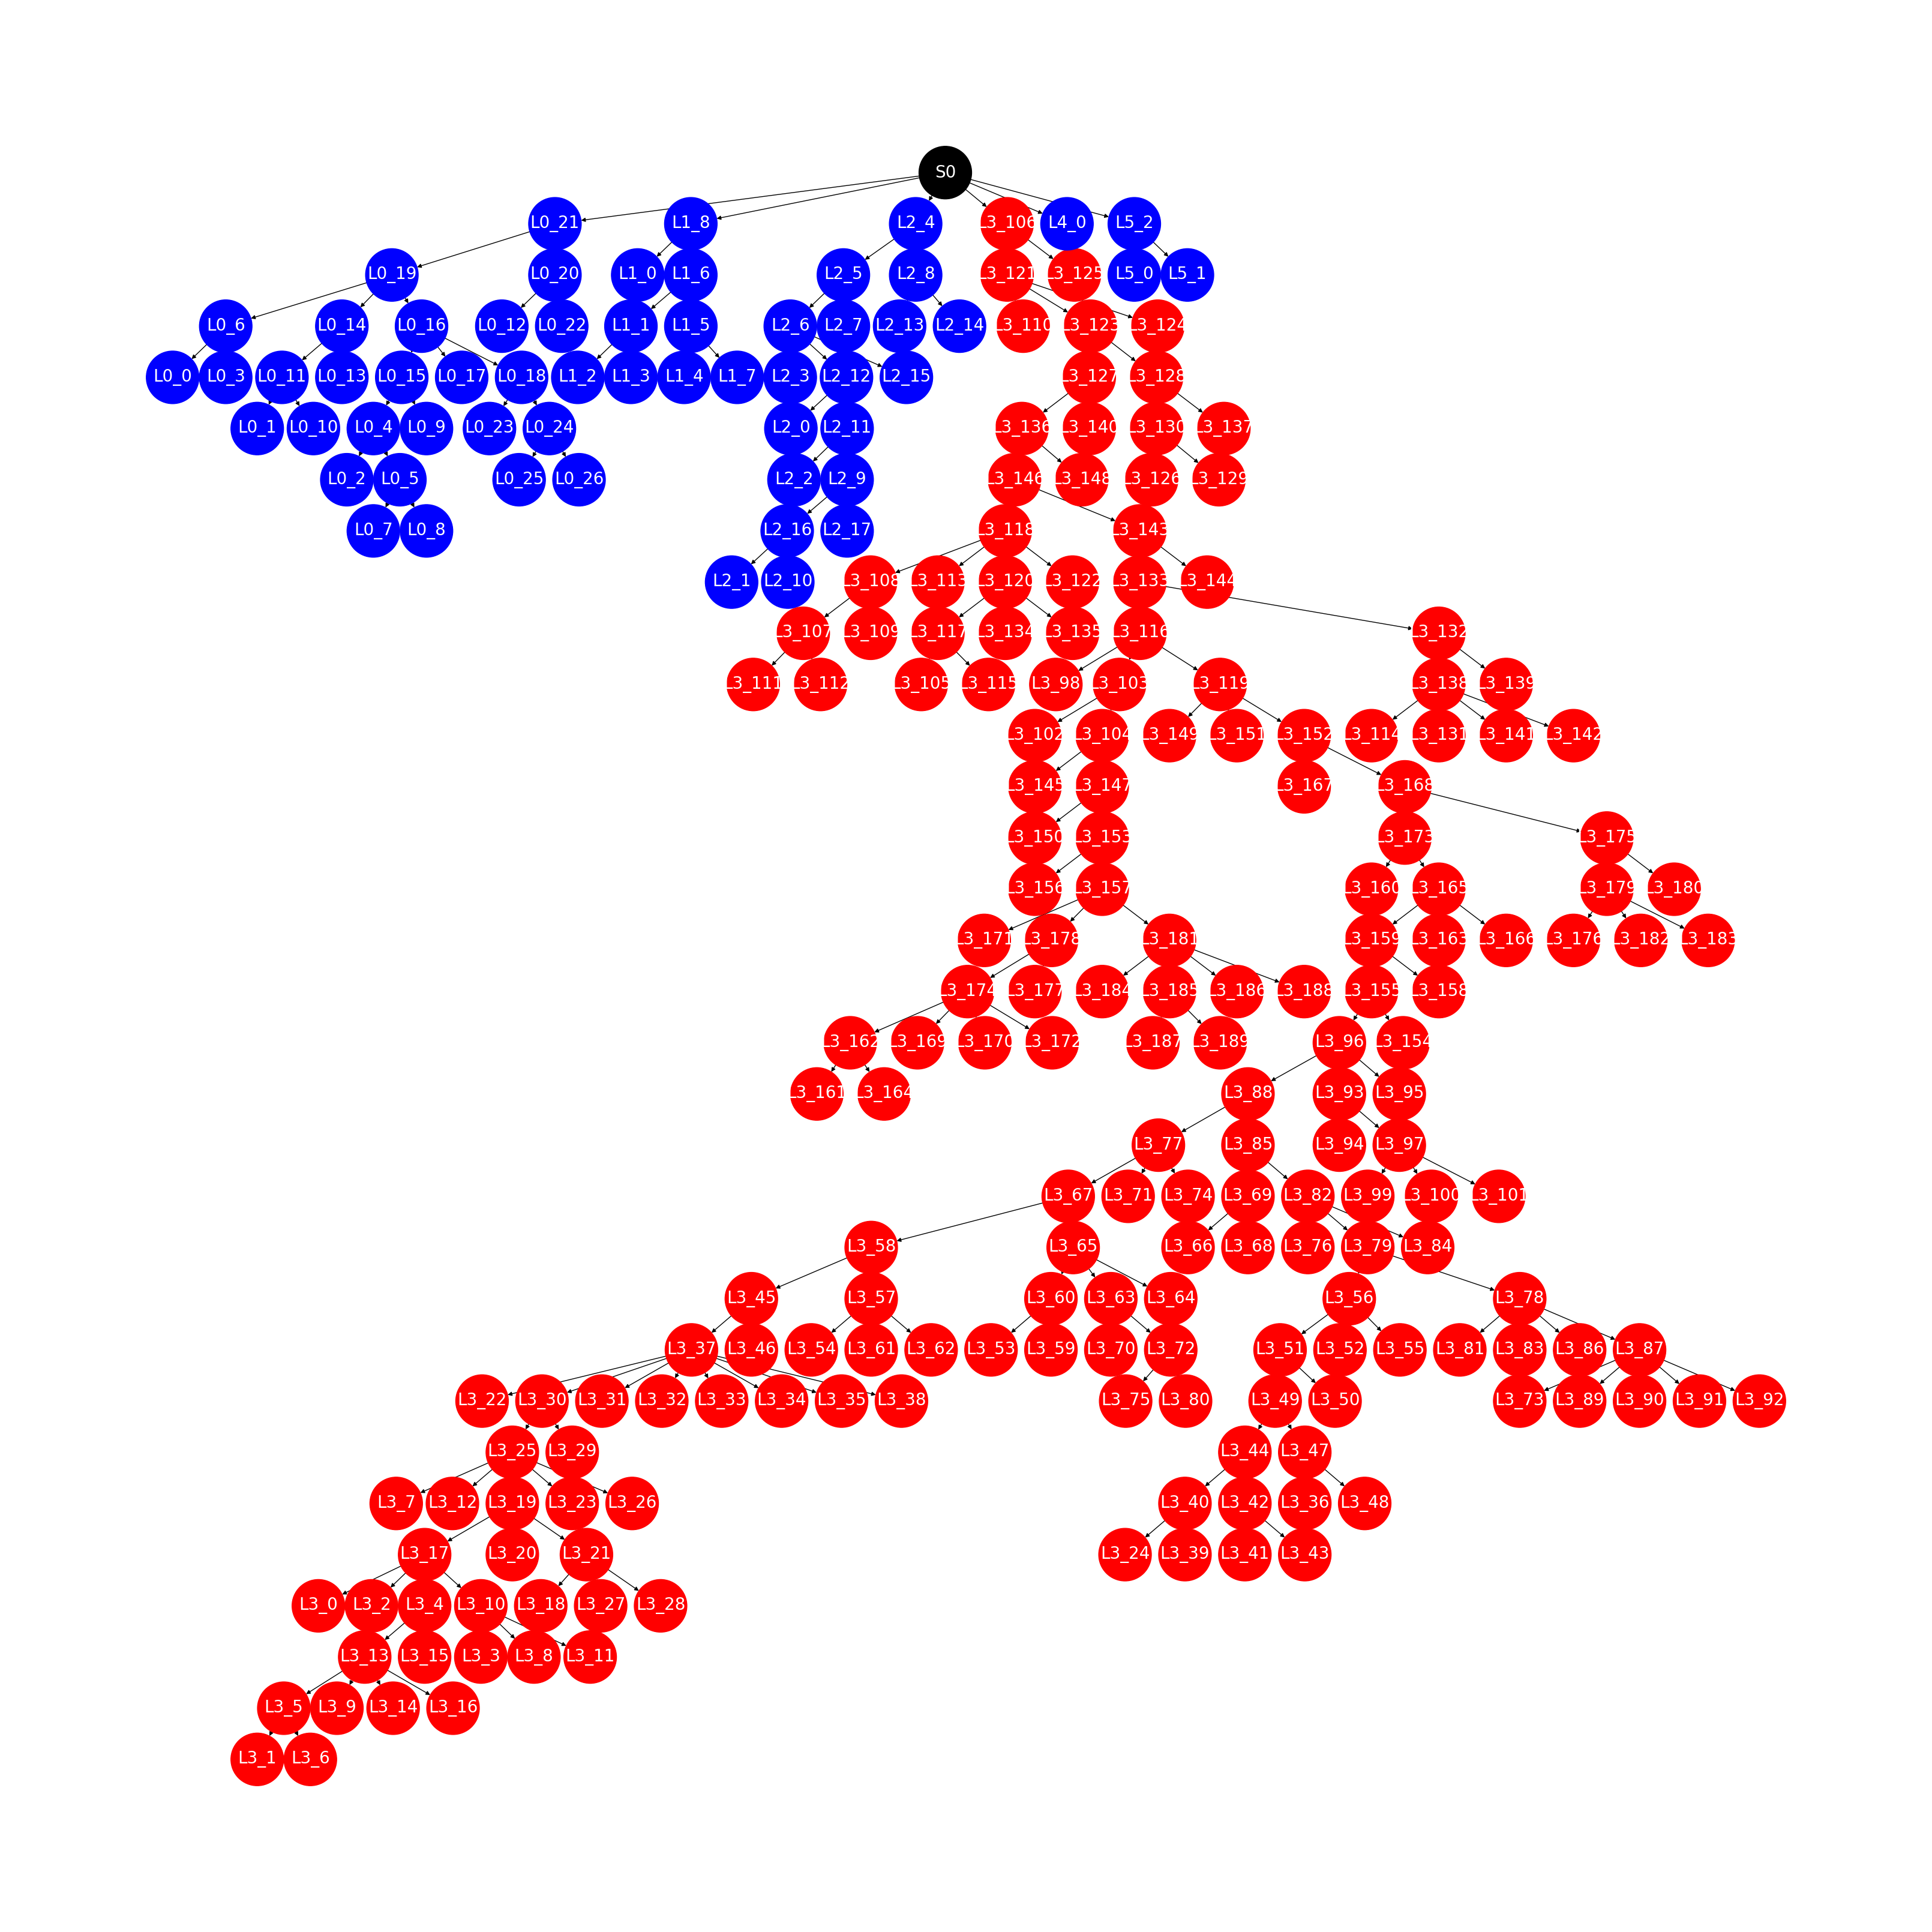

In [10]:
from neuron_morphology_tools import neuron_nx_utils as nxu
nxu.draw_tree(stage_products.neuron_graph_high_fid_axon)

# Creating the sonata file to go with the lite model

## utility functions

In [214]:
import logging
import sys

logging = reload(logging)

logging.basicConfig(
    format='%(message)s',
    level=logging.INFO, 
    stream=sys.stdout
)
logger = logging.getLogger("notebook")

logger.debug('Hello world!')

import h5py
def explore_structure(
    name, obj, 
    print_dataset=False,
    datasets_to_print=None):
        
    if datasets_to_print is None:
        datasets_to_print = []
    if isinstance(obj, h5py.Group):
        logger.info(f"{name} (Group) ")
    elif isinstance(obj, h5py.Dataset):
        print(f"{name} (Dataset), shape: {obj.shape}, dtype: {obj.dtype}")
        if print_dataset and name in datasets_to_print:
            logger.info(f"  data = {obj[:]}")

    #print out the attributes
    for k,v in obj.attrs.items():
        logger.info(f"   {k}:{v}")

def display_h5_filestructure(filepath):
    with h5py.File(filepath) as file:
        file.visititems(explore_structure)

def dataframe_to_datasets(
    df,
    obj=None,
    filepath="default_h5_file.h5",
    ):
    """
    Convert a Pandas DataFrame to an HDF5 file.
    - Columns of type 'object' are stored as 2D arrays.
    - Other columns are stored as 1D arrays.
    
    Args:
    df: The pandas DataFrame to convert.
    file_path: The output path for the HDF5 file.
    """
    need_close = False
    if obj is None:
        need_close = True
        obj = h5py.File(filepath,"w")
        
    for col in df.columns:
        logger.debug(f'Working on column: {col}')
        col_data = df[col]

        # If the column is of type 'object', reshape it into a 2D array
        if col_data.dtype == 'object':
            # Convert object-type column to a 2D NumPy array (reshaping into 2D)
            obj_array = np.vstack(col_data.values)
            obj.create_dataset(col, data=obj_array)
        else:
            # Store other columns as 1D NumPy arrays
            obj.create_dataset(col, data=col_data.values)

    if need_close:
        logger.info(f"HDF5 file '{filepath}' created successfully.")
        obj.close()
    

## Assembling Dataframes and node/edge indexes

In [ ]:
from datasci_tools import networkx_utils as xu
from datasci_tools import pandas_utils as pu

In [11]:
G = stage_products.neuron_graph_high_fid_axon

In [99]:
data_not_to_export = [
    "skeleton_data",
    "width_data",
    "synapse_data",
    "spine_data",
    "width_new",
    "boutons_cdfs",
    "boutons_volume",
    "labels",
    "soma_start_vec",
    "soma_start_angle",
    
    # defeats purpose if dividing by type
    "axon_compartment",
    "compartment"
]

compartment_list = ['soma','dendrite','axon']
compartment_map = {k:i for i,k in enumerate(compartment_list)}
compartment_data_not_to_export = dict(
    soma = [],
    dendrite = [],
    axon = [],   
)

compartment_graphs = dict([
    (k,xu.node_query_subgraph(G,f'compartment not in {compartment_list}')) if k=='dendrite' 
    else (k,xu.node_query_subgraph(G,f'compartment == "{k}"'))
    for k in compartment_list
])

# creating the group id
node_group_index_map = dict()
for c,cG in compartment_graphs.items():
    current_nodes = cG.nodes()
    counter = 0
    for n in current_nodes:
        node_group_map[node_map[k]] = compartment_map[c]
        node_group_index_map[node_map[k]] = counter
        counter += 1

compartment_dfs = {
    k:xu.node_df(
    compartment_graphs[k],
    properties_to_exclude=data_not_to_export + compartment_data_not_to_export[k]
    ) for k in compartment_list
}

def replace_column_as_xyz(
    df,
    column = "mesh_center",
    expanded_columns = ('x','y','z')
): 
    """
    Purpose: To replace the 3 element vector column specified
    as the x/y/z columns (or whatever specified
    """
    if column not in df.columns:
        return 
    df[list(expanded_columns)] = np.vstack(df[column].to_numpy()).astype('float')
    df.drop(columns = [column],inplace = True)

for v in compartment_dfs.values():
    replace_column_as_xyz(v)
    
compartment_dfs['axon']


,u,area,children_skeletal_angle_max,children_skeletal_angle_min,endpoint_downstream,endpoint_upstream,mesh_volume,min_dist_synapses_post_downstream,min_dist_synapses_post_upstream,min_dist_synapses_pre_downstream,min_dist_synapses_pre_upstream,n_boutons,n_spines,n_synapses,n_synapses_head,n_synapses_neck,n_synapses_no_head,n_synapses_post,n_synapses_pre,n_synapses_shaft,n_synapses_spine,parent_skeletal_angle,siblings_skeletal_angle_max,siblings_skeletal_angle_min,skeletal_length,skeleton_vector_downstream,skeleton_vector_upstream,soma_distance_euclidean,soma_distance_skeletal,spine_density,spine_volume_density,spine_volume_median,synapse_density,synapse_density_post,synapse_density_pre,total_spine_volume,width,width_downstream,width_upstream,x,y,z
0,L3_106,25.752236,64.72,41.01,"[557123.1, 763979.5, 1052678.0]","[552491.0, 757414.8, 1044274.0]",3.685737,1.068004e+04,1040.981589,inf,inf,0,0,2,0,0,0,2,0,0,0,NaN,-1.00,-1.00,12419.388881,"[0.372407875479804, 0.5871728779537941, 0.7187...","[0.4930627868884716, 0.6208323640182982, 0.609...",0.000000,0.000000,0.0,0,0,0.000161,0.000161,0.000000,0,471.146172,231.223807,415.364641,554833.812740,760574.445998,1.047842e+06
1,L3_121,10.628289,107.88,25.61,"[557065.1600564608, 769779.721914569, 1054542....","[557123.1, 763979.5, 1052678.0]",1.064569,inf,inf,inf,inf,0,0,0,0,0,0,0,0,0,0,41.01,101.48,101.48,6505.469226,"[0.09048208065188557, 0.9578546256766926, 0.27...","[-0.07132814096274286, 0.9470379855049598, 0.3...",11626.644077,12419.388881,0.0,0,0,0.000000,0.000000,0.000000,0,383.843606,239.450396,256.296268,556959.343284,766794.226617,1.053637e+06
2,L3_125,1.933679,-1.00,-1.00,"[557802.0, 763182.0, 1054011.0]","[557123.1, 763979.5, 1052678.0]",0.086170,inf,inf,inf,inf,0,0,0,0,0,0,0,0,0,0,64.72,101.48,101.48,1809.373178,"[0.4590060189312185, -0.4680515366716555, 0.75...","[0.25816308759512707, -0.4697390489237293, 0.8...",11626.644077,12419.388881,0.0,0,0,0.000000,0.000000,0.000000,0,181.819666,195.597592,195.597592,557474.417045,763669.076136,1.053150e+06
3,L3_110,4.789673,-1.00,-1.00,"[554280.6, 771769.6, 1050104.0]","[557065.1600564608, 769779.721914569, 1054542....",0.154414,inf,inf,inf,inf,0,0,0,0,0,0,0,0,0,0,88.83,156.98,107.41,6178.710578,"[-0.5820268510097933, 0.3600107472491658, -0.7...","[-0.40455947824858385, 0.3049594081177182, -0....",16710.676832,18924.858107,0.0,0,0,0.000000,0.000000,0.000000,0,134.041424,119.515003,132.530625,556271.859615,770652.860577,1.052642e+06
4,L3_123,2.902107,114.27,18.60,"[558495.8, 772350.2, 1055803.0]","[557065.1600564608, 769779.721914569, 1054542....",0.172236,inf,inf,inf,inf,0,0,0,0,0,0,0,0,0,0,25.61,107.41,84.78,3617.426555,"[0.36658468983501064, 0.8593023183166401, 0.35...","[0.4771025434592066, 0.7825331926572734, 0.400...",16710.676832,18924.858107,0.0,0,0,0.000000,0.000000,0.000000,0,252.080318,136.391952,140.103957,557658.495690,771465.306034,1.055173e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,L3_9,2.332747,-1.00,-1.00,"[445967.9, 814600.6, 1008908.0]","[446840.2119258637, 814844.1921963055, 1010317...",0.368775,inf,inf,1573.029289,740.041228,0,0,1,0,0,0,0,1,0,0,124.34,162.92,7.59,2313.070517,"[-0.5099833822256437, -0.02414531552427401, -0...","[-0.45998957504759536, -0.4355398162505757, -0...",124952.989687,337338.471163,0.0,0,0,0.000432,0.000000,0.000432,0,161.599999,168.111764,168.111764,446581.619231,815181.645192,1.009697e+06
186,L3_14,1.455553,-1.00,-1.00,"[447090.1, 816222.4, 1012171.0]","[446840.2119258637, 814844.1921963055, 1010317...",0.041234,inf,inf,inf,inf,0,0,0,0,0,0,0,0,0,0,58.36,162.92,31.98,3124.683148,"[0.07699623005271812, 0.6441458859007356, 0.76...","[0.18756413435716968, 0.41492183285372924, 0.8...",124952.989687,337338.471163,0.0,0,0,0.000000,0.000000,0.000000,0,199.121818,87.202957,128.620958,446873.690625,815950.934375,1.011139e+06
187,L3_16,6.281118,-1.00,-1.00,"[447203.3,

In [185]:

# generates the node and edge ids after the groups have been made
# creating the node and edge ids

## -- nodes ---
node_name = 'u'
node_list = []

type_offset = 100

# maps the networkx names to indexes
node_id_map = {}

# helper for creating the node ids
node_counter = 0

# tells what group id and index of each node
node_group_id = []
node_group_index = []

for comp,comp_df in compartment_dfs.items():
    curr_nodes = comp_df[node_name].to_list()
    node_list += curr_nodes
    n_nodes = len(curr_nodes)

    # creates the node mapping
    node_id_map.update({n:i+node_counter for i,n in enumerate(curr_nodes)})
    node_counter += n_nodes

    # creates the group_id
    node_group_id += n_nodes*[compartment_map[comp]]
    node_group_index += list(np.arange(0,n_nodes))

node_id = np.arange(len(node_list))
node_type_id = np.array(node_group_id) + type_offset
node_group_id
node_group_index

## -- edges ---
# Creating all of the edge datasets
edges = list(G.edges())
n_edges = len(edges)

edge_type_id = np.zeros(n_edges)
source_node_id = [node_id_map[k] for k,v in edges]
target_node_id = [node_id_map[v] for k,v in edges]
edge_group_id = np.zeros(n_edges) + type_offset
edge_group_index = np.arange(len(edges))
edge_id = np.arange(len(edges))

In [ ]:
"""
-- Optional --
Purpose: Want to replace columns with mulitdimensional arrays 
"""


"skeleton_vector_upstream",
"skeleton_vector_downstream",
"mesh_center",
"endpoint_upstream",
"endpoint_downstream",
"side_length_ratios",
"""

## Setting up the directory and config files

In [298]:
# json util files
def write_json(json_dict,filepath):
    with open(filepath,"w") as file:
        json.dump(json_dict,file,)
def read_json(filepath):
    with open(cfg_filepath,"r") as file:
        mydict = json.load(file)
    return mydict

def print_json(
    mydict,
    offset = "",
    additional_offset = "   "
):
    for k,v in mydict.items():
        if isinstance(v,dict):
            print(f"{offset}{k}:")
            print_json(v,offset=offset+additional_offset)
        else:
            print(f"{offset}{k}:{v}")

In [284]:
# creating the filepaths

from pathlib import Path
seg_directory = Path(f"./{segment_id}")
seg_directory.mkdir(exist_ok = True)

# --- network files
network_directory = seg_directory / Path("network")
network_directory.mkdir(exist_ok = True)

node_filepath = network_directory / Path(f"node.h5")
edge_filepath = network_directory / Path(f"edges.h5")

node_type_filepath = network_directory / Path("node_type.csv")
edge_type_filepath = network_directory / Path("edge_type.csv")

# -- morphology files (currently not used) --
morphology_directory = seg_directory / Path("morphologies")
morphology_directory.mkdir(exist_ok = True)

In [277]:
# creating the config file
import json

relative_directory = "./"
nx_cfg_filepath = Path(seg_directory) / Path("./circuit_config.json")
sim_cfg_filepath = Path(seg_directory) / Path("./simulation_config.json")

cfg_filepath = seg_directory / Path("./config.json")

cfg_dict = dict(
    network=f"./{nx_cfg_filepath.relative_to(seg_directory)}",
    simulation = f"./{sim_cfg_filepath.relative_to(seg_directory)}",
)

write_json(cfg_dict,cfg_filepath)

{'network': './circuit_config.json', 'simulation': './simulation_config.json'}

In [291]:
# with open("./circuit_config.json","r") as file:
#     mydict = json.load(file)
# print_json(mydict)

manifest:
   $NETWORK_DIR:./network
   $COMPONENT_DIR:../shared_components
components:
   morphologies_dir:$COMPONENT_DIR/morphologies
   synaptic_models_dir:$COMPONENT_DIR/synaptic_models
   mechanisms_dir:$COMPONENT_DIR/mechanisms
   biophysical_neuron_models_dir:$COMPONENT_DIR/biophysical_neuron_templates/nml
networks:
   nodes:[{'nodes_file': '$NETWORK_DIR/internal_nodes.h5', 'node_types_file': '$NETWORK_DIR/internal_node_types.csv'}, {'nodes_file': '$NETWORK_DIR/external_nodes.h5', 'node_types_file': '$NETWORK_DIR/external_node_types.csv'}]
   edges:[{'edges_file': '$NETWORK_DIR/internal_internal_edges.h5', 'edge_types_file': '$NETWORK_DIR/internal_internal_edge_types.csv'}, {'edges_file': '$NETWORK_DIR/external_internal_edges.h5', 'edge_types_file': '$NETWORK_DIR/external_internal_edge_types.csv'}]


In [296]:
net_path = "$NETWORK_DIR"
net_path_str = f"./" + str(
    network_directory.relative_to(seg_directory))

node_filepath = network_directory / Path(f"node.h5")
edge_filepath = network_directory / Path(f"edges.h5")

node_type_filepath = network_directory / Path("node_type.csv")
edge_type_filepath = network_directory / Path("edge_type.csv")


morphology_dir_str = f"{net_path}/" + str(
    morphology_directory.relative_to(seg_directory))

nodes_file_str = f"{net_path}/" + str(
   node_filepath.relative_to(network_directory) )
node_types_file_str = f"{net_path}/" + str(
   node_type_filepath.relative_to(network_directory) )

edges_file_str = f"{net_path}/" + str(
   edge_filepath.relative_to(network_directory) )
edge_types_file_str = f"{net_path}/" + str(
   edge_type_filepath.relative_to(network_directory) )


nx_cfg_dict = {
    "manifest":{
        net_path:net_path_str,
        "$COMPONENT_DIR":None,
    },
    "components":{
        "morphologies_dir":morphology_dir_str
    },
    "networks":{
        "nodes":[
            {
                "nodes_file":nodes_file_str,
                "node_types_file":node_types_file_str,
            }
        ],
        "edges":[
            {
                "edges":edges_file_str,
                "edges_types_file":edge_types_file_str,
            }
        ],
    }
}

print_json(nx_cfg_dict)

manifest:
   $NETWORK_DIR:./network
   $COMPONENT_DIR:None
components:
   morphologies_dir:$NETWORK_DIR/morphologies
networks:
   nodes:[{'nodes_file': '$NETWORK_DIR/node.h5', 'node_types_file': '$NETWORK_DIR/node_type.csv'}]
   edges:[{'edges': '$NETWORK_DIR/edges.h5', 'edges_types_file': '$NETWORK_DIR/edge_type.csv'}]


In [299]:
write_json(nx_cfg_dict,nx_cfg_filepath)
write_json(dict(),sim_cfg_filepath)

## Creating the node.h5 file

In [300]:
import h5py

"""
Purpose: want to create the h5 file that will hold the node groups and populations

nodes/internal/[0/1/2]/attributes

nodes/internal/node_group_id
nodes/internal/node_group_index
nodes/internal/node_id
nodes/internal/node_type_id #where will store the compartment

"""


logger.setLevel(logging.INFO)

with h5py.File(node_filepath,"w") as file:

    pop = file.create_group('nodes/0')

    """
    Creating the node id datasets

    node_id
    node_type_id
    node_group_id
    node_group_index
    
    """
    pop.create_dataset("node_type_id",data=node_type_id)
    pop.create_dataset("node_id",data=node_id)
    pop.create_dataset("node_group_id",data=node_group_id)
    pop.create_dataset("node_group_index",data=node_group_index)

    for comp,group_id in compartment_map.items():
        obj = pop.create_group(f"{group_id}")
        df = compartment_dfs['axon']
        df_filt = pu.delete_columns(df,columns_to_delete=[node_name])
        
        dataframe_to_datasets(
            df_filt,
            obj = obj
        )

In [301]:
display_h5_filestructure(node_filepath)

nodes (Group) 
nodes/0 (Group) 
nodes/0/0 (Group) 
nodes/0/0/area (Dataset), shape: (190,), dtype: float64
nodes/0/0/children_skeletal_angle_max (Dataset), shape: (190,), dtype: float64
nodes/0/0/children_skeletal_angle_min (Dataset), shape: (190,), dtype: float64
nodes/0/0/endpoint_downstream (Dataset), shape: (190, 3), dtype: float64
nodes/0/0/endpoint_upstream (Dataset), shape: (190, 3), dtype: float64
nodes/0/0/mesh_volume (Dataset), shape: (190,), dtype: float64
nodes/0/0/min_dist_synapses_post_downstream (Dataset), shape: (190,), dtype: float64
nodes/0/0/min_dist_synapses_post_upstream (Dataset), shape: (190,), dtype: float64
nodes/0/0/min_dist_synapses_pre_downstream (Dataset), shape: (190,), dtype: float64
nodes/0/0/min_dist_synapses_pre_upstream (Dataset), shape: (190,), dtype: float64
nodes/0/0/n_boutons (Dataset), shape: (190,), dtype: int64
nodes/0/0/n_spines (Dataset), shape: (190,), dtype: int64
nodes/0/0/n_synapses (Dataset), shape: (190,), dtype: int64
nodes/0/0/n_synap

## Creating the edge.h5 file

In [302]:
"""
Purpose: want to generate the edge h5 file that will have all of the edges
between all of the node groups

Steps:
1) need to map the node names to the new node ids
- attribute of the dataset has to specify the source and target population name

Datasets to include
- /edges/<population_name>/edge_type_id
- /edges/<population_name>/source_node_id (with attribute specifying node population)
- /edges/<population_name>/target_node_id
- /edges/<population_name>/edge_group_id
- /edges/<population_name>/edge_group_index
- /edges/<population_name>/<group-id1>/my_attribute [pos_x/y/z]

Can make the location of the edge the upstream endpoint of the node and make that the xyz


"""

'\nPurpose: want to generate the edge h5 file that will have all of the edges\nbetween all of the node groups\n\nSteps:\n1) need to map the node names to the new node ids\n- attribute of the dataset has to specify the source and target population name\n\nDatasets to include\n- /edges/<population_name>/edge_type_id\n- /edges/<population_name>/source_node_id (with attribute specifying node population)\n- /edges/<population_name>/target_node_id\n- /edges/<population_name>/edge_group_id\n- /edges/<population_name>/edge_group_index\n- /edges/<population_name>/<group-id1>/my_attribute [pos_x/y/z]\n\nCan make the location of the edge the upstream endpoint of the node and make that the xyz\n\n\n'

In [303]:
"""
Purpose: Want to generate a dataframe with the 
target attributes expanded into separate attribtues
"""
import pandas as pd
columns_to_expand = {
    "endpoint_upstream":"pos",
    "skeleton_vector_upstream":"dir",
}
expansion_suffixes = ['x','y','z']

edge_attr_df = pd.DataFrame()
for c,name in columns_to_expand.items():
    new_columns = [f"{name}_{k}" for k in expansion_suffixes]
    data = np.vstack([G.nodes[k[1]][c] for k in edges])
    edge_attr_df[new_columns] = data
edge_attr_df

,pos_x,pos_y,pos_z,dir_x,dir_y,dir_z
0,549714.000000,742862.000000,1.045330e+06,-0.565584,-0.776790,-0.276969
1,554532.726531,749895.985714,1.039790e+06,0.297941,-0.193173,-0.934834
2,561441.000000,752487.000000,1.055770e+06,0.712724,0.172856,0.679812
3,552491.000000,757414.800000,1.044274e+06,0.493063,0.620832,0.609472
4,556006.000000,754120.000000,1.042120e+06,0.789606,0.393049,-0.471206
...,...,...,...,...,...,...
243,446840.211926,814844.192196,1.010318e+06,0.247282,0.817914,0.519489
244,445437.600000,813776.800000,1.008389e+06,-0.599456,-0.443636,-0.666213
245,445437.600000,813776.800000,1.008389e+06,0.294706,-0.951976,-0.083006
246,544710.000000,751103.000000,1.056360e+06,-0.713554,0.186839,0.675227


In [304]:
with h5py.File(edge_filepath,"w") as file:
    #creating the population group
    obj = file.create_group("edges/0")

    # create all the ids and indexes
    obj.create_dataset("edge_type_id",data = edge_type_id)
    source = obj.create_dataset("source_node_id",data = source_node_id)
    source.attrs["node_population"] = "0"  
    target = obj.create_dataset("target_node_id",data = target_node_id)
    target.attrs["node_population"] = "0"  
    obj.create_dataset("edge_group_id",data = edge_group_id)
    obj.create_dataset("edge_group_index",data = edge_group_index)
    obj.create_dataset("edge_id",data = edge_id)

    # create the group to hold the positions
    obj = file.create_group("edges/0/0")

    edge_attr_df

    dataframe_to_datasets(
        edge_attr_df,
        obj = obj
    )


display_h5_filestructure(edge_filepath)

edges (Group) 
edges/0 (Group) 
edges/0/0 (Group) 
edges/0/0/dir_x (Dataset), shape: (248,), dtype: float64
edges/0/0/dir_y (Dataset), shape: (248,), dtype: float64
edges/0/0/dir_z (Dataset), shape: (248,), dtype: float64
edges/0/0/pos_x (Dataset), shape: (248,), dtype: float64
edges/0/0/pos_y (Dataset), shape: (248,), dtype: float64
edges/0/0/pos_z (Dataset), shape: (248,), dtype: float64
edges/0/edge_group_id (Dataset), shape: (248,), dtype: float64
edges/0/edge_group_index (Dataset), shape: (248,), dtype: int64
edges/0/edge_id (Dataset), shape: (248,), dtype: int64
edges/0/edge_type_id (Dataset), shape: (248,), dtype: float64
edges/0/source_node_id (Dataset), shape: (248,), dtype: int64
   node_population:0
edges/0/target_node_id (Dataset), shape: (248,), dtype: int64
   node_population:0


## generate node_type.csv

In [305]:
deliminator = " "
def save_type_csv(df,filepath):
    df.to_csv(
        filepath,
        sep = deliminator,
        header = True
    )

In [306]:
"""
Purpose: want to generate the csv file for the different 
node lists
"""

node_type_columns = [
    "node_type_id",
    "model_type",
    #"morphology",
    #"model_name",
    "compartment"
]

import pandas as pd
df_dict = dict(
    node_type_id = [k+ + type_offset for k in compartment_map.values()],
    model_type = "morphology", # point_neuron
    compartment = list(compartment_map.keys()) 
    
)

node_type_df = pd.DataFrame(df_dict)
node_type_df

,node_type_id,model_type,compartment
0,100,morphology,soma
1,101,morphology,dendrite
2,102,morphology,axon


In [307]:
save_type_csv(node_type_df,node_type_filepath)

## generate edge_type.csv

In [308]:
edge_type_columns = [
    "edge_type_id",
    "model_template"
]

df_dict_edge = dict(
    edge_type_id = [type_offset],
    model_template = None
)

edge_type_df = pd.DataFrame(df_dict_edge)
edge_type_df


,edge_type_id,model_template
0,100,None


In [309]:
save_type_csv(edge_type_df,edge_type_filepath)